# Introduction
This notebook is an implementation of experiments described in the paper "Towards story-related classification of movie scenes", which is submitted to the collection of "Science of Stories", at Plos One (url of the paper will be updated after acceptance).

The features are stored in `data/features/` and the labels are stored in `data/final_annotations`, which are used in this notebook. If you are interested in the feature extraction and label computation process, please contact me: liuc@post.bgu.ac.il.

# Basic Settings

First we set up the data and label directories, indicate the episodes we are going to use in the experiments, and define the feature and label list.

In [19]:
SEASON_EP = {'1': 28,
             '2': 32,
             '3': 1}
def generate_ep(SEASON_EP):
    ep_list = []
    for season in SEASON_EP:
        ep_list += ['S'+season+'E'+str(ep) for ep in range(1, SEASON_EP[season]+1)]
    ep_list.remove('S1E1')
    return ep_list

EP_LIST = generate_ep(SEASON_EP)

group_ep = {}
for i in range(60):
    group_ep[str(i+1)] = EP_LIST[i]

label_list = list([
    "Inciting incident",
    "Climax 1",
    "Obstacle",
    "Midpoint",
    "Disaster",
    "Crisis",
    "Climax 2",
    "Climax 3",
    "Wrap-up",
    "Non-Key"
])

reduce_list = []

raw_feature_dir = './data/features/'
raw_label_dir = './data/final_annotations/'

feature_list = ['id', 'clos_beg_id', 'r_id_loc', 'start_time', 'dur', 'r_t_loc', 'sec', 
                'clock_drift', 'protagonist_appear', 'ava_charNet_score']

Then import the packages we are going to use, and define some useful functions.

In [2]:
import os
import re
from fractions import Fraction
import pandas as pd
import numpy as np
from numpy.linalg import norm
import shap
import xgboost

from scipy.stats import entropy, ttest_rel, sem

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import normalize
from sklearn.preprocessing import LabelBinarizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import cross_validate
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.preprocessing import normalize
from sklearn.metrics import make_scorer

from xgboost import XGBClassifier
from xgboost import plot_importance

from collections import Counter

from matplotlib import pyplot
import matplotlib.pyplot as plt

# Data analytics and preprocessing
Now we will load the data and labels and analyze the agreement among human annotators. The data will be over-sampled for training. 

In [4]:
def label_string_to_tuple(y, class_reduce_list=[]):
    """
    Originally, the annotations are in the format of strings.
    We need to convert it into tuple format for future operating.
    
    @input: df_label, a DataFrame format data structure that is read from csv using pd.read_csv()
    @output: labels_tuple, a list, each element is a list of tuples: (label, prob)
    """
    
    y_tuple = []
    
    for label in y['Label'].values:
        labels = re.findall('\(([^)]+)', label[1:-1])
        label_per_scene = []
        prob_nk = 0
        for l in labels:
            lab = l.split(',')[0][1:-1]
            prob = float(l.split(',')[1][1:])
            if lab in class_reduce_list:
                prob_nk += prob
            else:
                label_per_scene.append((lab, prob))
        if prob_nk != 0:
            label_per_scene.append(('Non-Key', prob_nk))
        scene_label = np.array(label_per_scene, dtype=object)
        y_tuple.append(scene_label)
    return np.array(y_tuple)

def find_least_multiple(y_tuple):
    num_annotators = []
    
    for scene in y_tuple:
        for s in scene:
            num_annotators.append(Fraction(s[1]).limit_denominator().denominator)
    unique = np.unique(num_annotators)
    least_multiple = np.lcm.reduce(unique)
    print("Found least common multiple: ", least_multiple)
    
    return least_multiple

def oversample_label(y_tuple, scale):  
    oversampled_label = []
    for scene in y_tuple:
        oversampled_scene_labels = []
        for i in range(1, len(scene) + 1):
            oversampled_scene_labels += [scene[i-1][0]] * round(scene[i-1][1] * int(scale))
        oversampled_label.append(oversampled_scene_labels)
        
    oversample_label = np.array(oversampled_label)
    print(oversample_label.shape)
    
    y_sampled = []
    for i in range(oversample_label.shape[1]):
        y_sampled += list(oversample_label[:,i])
    
    return np.array(y_sampled)

def least_multiple_oversample(X, y):
    oversample_scale = find_least_multiple(y)
    
    # oversample features
    X_sampled = np.tile(X, (oversample_scale, 1))

    # oversample labels
    y_sampled = oversample_label(y, oversample_scale)
    
    return X_sampled, y_sampled, oversample_scale

def label_to_numbers(y_sampled):
    y_number_sampled = []
    
    for y in y_sampled:
        y_number_sampled.append(label_list.index(y) + 1)
        
    return np.array(y_number_sampled)

In [5]:
def load_data(EP_LIST, 
              sample=True, 
              class_reduce=False, 
              return_tuple=False):
    X_column_headers = feature_list
    y_column_headers = ['Label']
    X = pd.DataFrame(columns=X_column_headers)
    y = pd.DataFrame(columns=y_column_headers)
    
    for ep in EP_LIST:
        data_file = raw_feature_dir + ep + '-Scenes.csv'
        label_file = raw_label_dir + 'Final_Labels_' + ep + '.csv'
        
        ep_df = pd.read_csv(data_file, usecols=X_column_headers)
        label_df = pd.read_csv(label_file, header=None, usecols=[1] ,names=y_column_headers)
        
        X = X.append(ep_df, sort=False)
        y = pd.concat([y, label_df])
    if not class_reduce:
        y_tuple = label_string_to_tuple(y)
    else:
        y_tuple = label_string_to_tuple(y, class_reduce_list=reduce_list)
    
    if sample:
        X_data, y_data, scale = least_multiple_oversample(X.values, y_tuple)
        y_data = label_to_numbers(y_data)
    else:
        pass
    
    if return_tuple:
        return y_tuple
    else:
        return X_data, y_data, scale

def group_generation(X, scale):
    scene_id = list(X[:int(len(X)/scale),0])
    group_ep = []

    num_scenes = []
    count = 1
    for i in range(len(scene_id)):
        if scene_id[i] == 1.0:
            num_scenes.append(count)
            count = 1
        else:
            count += 1

    num_scenes.remove(1.0)
    num_scenes.append(scene_id[-1])

    for i in range(1, len(num_scenes) + 1):
        group_ep += [i] * int(num_scenes[i-1])
    
    groups = group_ep * scale
    return groups

In [6]:
def get_scene_majority(scene_annotations):
    if len(scene_annotations) == 1:
        label = scene_annotations[0][0]
        prob = scene_annotations[0][1]
        return label, prob
    else:
        for annotation in scene_annotations:
            label = annotation[0]
            prob = annotation[1]
            if prob >= 0.5:
                return label, prob
    return None, None

Set `return_tuple` to `True` in order to obtain the label in tuples, so that we can compute the human agreement.

In [7]:
y_tuple = load_data(EP_LIST, return_tuple=True)

Found least common multiple:  60
(1569, 60)


In [8]:
label_statistic = {
    'disagree': 0,
    'agree': 0,
    'major_nk': 0,
    'all_nk': 0,
    'major_k': 0,
    'all_k': 0
}
for a in y_tuple:
    label, prob = get_scene_majority(a)
    if not label:
        label_statistic['disagree'] += 1
    else:
        label_statistic['agree'] += 1
        if label == 'Non-Key':
            label_statistic['major_nk'] += 1
            if prob == 1.0:
                label_statistic['all_nk'] += 1
        else:
            label_statistic['major_k'] += 1
            if prob == 1.0:
                label_statistic['all_k'] += 1

In [9]:
label_statistic

{'disagree': 117,
 'agree': 1452,
 'major_nk': 999,
 'all_nk': 625,
 'major_k': 453,
 'all_k': 92}

Now we load the data for classification, and the data is automatically oversampled.

In [10]:
X, y, scale = load_data(EP_LIST)
GROUP_EP=group_generation(X, scale)
print(X.shape, y.shape)

Found least common multiple:  60
(1569, 60)
(94140, 10) (94140,)


# Build models
In this section we define the custome scoring metrics, build up baseline models and XGBoost models.
## Define custome scoring metrics used by sklearn
We define two custome scoring metrics: cosine similarity and KL divergence. 

In [13]:
def sampling_restore(X_sampled, y_sampled):
    if int(len(X_sampled)/60) != int(len(y_sampled)/60):
        print("Wrong shape when doing sampling restore!")
    
    ep_len = int(len(X_sampled)/60)
    X_restore = X_sampled[:ep_len]

    y_restore = np.zeros((ep_len, len(label_list)))

    for i, label in enumerate(y_sampled):
        y_restore[i%ep_len, (label-1)] += 1

    y_restore = y_restore/60
    
    if not reduce_list:
        return X_restore, y_restore
    else:
        reduce_idx = np.array([label_list.index(l) for l in reduce_list if l != 'Non-Key'])
        y_restore = np.delete(y_restore, reduce_idx, axis=1)
        return X_restore, y_restore

def full_label_vector(y):
    y_full = np.zeros((y.shape[0], len(label_list)), dtype=np.float32)
    for index, new_y in enumerate(y_full):
        for annotation in y[index]:
            label, prob = annotation[0], annotation[1]
            new_y[label_list.index(label)] = prob  
    return y_full

In [14]:
def compute_kl_divergence(pk, qk):
    '''
    pk: true distribution
    qk: predicted distribution
    '''
    return entropy(pk, qk)

def compute_cosine_similarity(pk, qk):
    return np.inner(pk, qk)/(norm(pk) * norm(qk))

Here we need a back up of results from different models, so that they will not be overrided and we can further analyze the results later.

In [15]:
the_model = None
model_label_similarity = {'Logistic': [],
                          'XGBoost': [],
                          'XGBoost_basic': [],
                          'XGBoost_Label_reduce': []
                         }

model_kl_divergence = {'Logistic': [],
                       'XGBoost': [],
                       'XGBoost_basic': [],
                       'XGBoost_Label_reduce': []
                      }

In [17]:
## Implementation of our customized score function
## It measure the similarity and Kl divergence between predict class probability vectors and the true class distribution
def similarity_scoring(model, X, y):
    X_restore, y_restore = sampling_restore(X, y)
    y_predict_proba = model.predict_proba(X_restore)
    
    if the_model not in model_label_similarity:
        model_label_similarity[the_model] = []
    
    similarity = np.zeros(y_restore.shape[0])
    if y_restore.shape == y_predict_proba.shape:
        for i in range(y_restore.shape[0]):
            similarity[i] = compute_cosine_similarity(y_restore[i], y_predict_proba[i])
    else:
        print("Wrong shape when calculating similarity!")
        print("Predicted shape: ", y_predict_proba.shape)
        print("Restored shape: ", y_restore.shape)
    
    label_similarity = np.zeros((y_restore.shape[1]))
    for i in range(y_restore.shape[1]):
        label_similarity[i] = compute_cosine_similarity(y_restore[:, i], y_predict_proba[:, i])
    
    model_label_similarity[the_model].append(label_similarity)
    
    return np.average(similarity)

def kl_divergence_scoring(model, X, y):
    X_restore, y_restore = sampling_restore(X, y)
    y_predict_proba = model.predict_proba(X_restore)
    
    if the_model not in model_kl_divergence:
        model_kl_divergence[the_model] = []
    
    kl_divergence = np.zeros(y_restore.shape[0])
    if y_restore.shape == y_predict_proba.shape:
        for i in range(y_restore.shape[0]):
            #Negative KL divergence because we need the score to be the higher the better.
            kl_divergence[i] = -compute_kl_divergence(y_restore[i], y_predict_proba[i])
    else:
        print("Wrong shape when calculating kl divergence!")
    
    label_kl_divergence = np.zeros((y_restore.shape[1]))
    for i in range(y_restore.shape[1]):
        label_kl_divergence[i] = compute_kl_divergence(y_restore[:, i], y_predict_proba[:, i])
        

    model_kl_divergence[the_model].append(label_kl_divergence)
    
    return np.average(kl_divergence)

## Baseline: Logistic Regression with all features

In [53]:
# Logistic Regression Baseline
X_normed = normalize(X, axis=0)

logo = LeaveOneGroupOut()
split = logo.split(X_normed, y, GROUP_EP)
scoring = {'Similarity': similarity_scoring,
           'KL_divergence': kl_divergence_scoring}

model = LogisticRegression(solver='lbfgs', multi_class='multinomial')

the_model = 'Logistic'

logistic_baseline = cross_validate(model, X_normed, y, cv=split, 
                                   scoring=scoring, 
                                   return_train_score=False, return_estimator=True, verbose=2)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  ................................................................
[CV] ................................................. , total=   1.7s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.7s remaining:    0.0s


[CV] ................................................. , total=   2.0s
[CV]  ................................................................
[CV] ................................................. , total=   2.2s
[CV]  ................................................................
[CV] ................................................. , total=   1.9s
[CV]  ................................................................
[CV] ................................................. , total=   1.8s
[CV]  ................................................................


/Users/liu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in double_scalars
  if __name__ == '__main__':
/Users/liu/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:2507: RuntimeWarning: invalid value encountered in true_divide
  pk = 1.0*pk / np.sum(pk, axis=0)


[CV] ................................................. , total=   1.9s
[CV]  ................................................................
[CV] ................................................. , total=   1.9s
[CV]  ................................................................
[CV] ................................................. , total=   1.7s
[CV]  ................................................................
[CV] ................................................. , total=   1.9s
[CV]  ................................................................
[CV] ................................................. , total=   1.7s
[CV]  ................................................................
[CV] ................................................. , total=   1.8s
[CV]  ................................................................
[CV] ................................................. , total=   1.8s
[CV]  ................................................................
[CV] .

/Users/liu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in double_scalars
  if __name__ == '__main__':
/Users/liu/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:2507: RuntimeWarning: invalid value encountered in true_divide
  pk = 1.0*pk / np.sum(pk, axis=0)


[CV] ................................................. , total=   1.6s
[CV]  ................................................................
[CV] ................................................. , total=   4.4s
[CV]  ................................................................
[CV] ................................................. , total=   4.0s
[CV]  ................................................................
[CV] ................................................. , total=   3.6s
[CV]  ................................................................
[CV] ................................................. , total=   2.5s
[CV]  ................................................................
[CV] ................................................. , total=   1.5s
[CV]  ................................................................
[CV] ................................................. , total=   1.4s
[CV]  ................................................................
[CV] .

/Users/liu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in double_scalars
  if __name__ == '__main__':
/Users/liu/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:2507: RuntimeWarning: invalid value encountered in true_divide
  pk = 1.0*pk / np.sum(pk, axis=0)


[CV] ................................................. , total=   1.8s
[CV]  ................................................................
[CV] ................................................. , total=   1.9s
[CV]  ................................................................
[CV] ................................................. , total=   2.6s
[CV]  ................................................................
[CV] ................................................. , total=   3.4s
[CV]  ................................................................
[CV] ................................................. , total=   2.1s
[CV]  ................................................................
[CV] ................................................. , total=   1.9s
[CV]  ................................................................
[CV] ................................................. , total=   1.9s
[CV]  ................................................................
[CV] .

[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:  2.1min finished


In [54]:
print('Logistic similarity: ava. %.3f, std. %.3f' % 
      (np.average(logistic_baseline['test_Similarity']), sem(logistic_baseline['test_Similarity'])))

print('Logistic kl_divergence: ava. %.3f, std. %.3f' % 
      (np.average(-logistic_baseline['test_KL_divergence']), sem(-logistic_baseline['test_KL_divergence'])))

Logistic similarity: ava. 0.718, std. 0.013
Logistic kl_divergence: ava. 1.046, std. 0.031


In [18]:
print('Label similarity, logistic_regression:')
print(np.nanmean(model_label_similarity['Logistic'], axis=0))
print(sem(model_label_similarity['Logistic'], axis=0, nan_policy='omit'))

Label similarity, logistic_regression:
[0.39681255 0.30731824 0.43604488 0.31855511 0.29038782 0.27896306
 0.34265871 0.28815421 0.24543012 0.8522055 ]
[0.0103945552203636 0.010760821066093789 0.011048450063420564
 0.01045791082063875 0.011179893658396783 0.010030956839975213
 0.010397671834218756 0.009022410356482902 0.005538135756269406
 0.007970536693395938]


In [19]:
print('Label kl_divergence, logistic_regression:')
print(np.nanmean(model_kl_divergence['Logistic'], axis=0))
print(sem(model_kl_divergence['Logistic'], axis=0, nan_policy='omit'))

Label kl_divergence, logistic_regression:
[1.94221775 2.45344329 1.64057095 2.33842889 2.58801494 2.65900122
 2.24461334 2.62540847 2.94150719 0.28739579]
[0.06040955106577388 0.06897400493097892 0.05430068546893383
 0.06383541765513992 0.07181458102070792 0.06769048860374526
 0.05890117881374444 0.062310744444273494 0.04863056666285239
 0.018756049387736236]


## XGBoost with all features

In [ ]:
# All features
scoring = {'Similarity': similarity_scoring,
           'KL_divergence': kl_divergence_scoring}

X_normed = normalize(X, axis=0)

the_model = 'XGBoost'
reduce_list = []

logo = LeaveOneGroupOut()
split = logo.split(X_normed, y, GROUP_EP)
model = OneVsRestClassifier(XGBClassifier())

scores_ova_xgb_all = cross_validate(model, X_normed, y, cv=split, 
                                    scoring=scoring, 
                                    return_train_score=False, return_estimator=True, verbose=2)

In [28]:
print('XGBoost similarity: ava. %.3f, std. %.3f' % 
      (np.average(scores_ova_xgb_all['test_Similarity']), sem(scores_ova_xgb_all['test_Similarity'])))

print('XGBoost kl_divergence: ava. %.3f, std. %.3f' % 
      (np.average(-scores_ova_xgb_all['test_KL_divergence']), sem(-scores_ova_xgb_all['test_KL_divergence'])))

XGBoost similarity: ava. 0.806, std. 0.009
XGBoost kl_divergence: ava. 0.668, std. 0.023


In [23]:
print('Label similarity, XGBoost:')
print(np.nanmean(model_label_similarity['XGBoost'], axis=0))
print(sem(model_label_similarity['XGBoost'], axis=0, nan_policy='omit'))

Label similarity, XGBoost:
[0.66709136 0.59020341 0.52033838 0.41998875 0.42481847 0.37981626
 0.51842901 0.64798601 0.88817035 0.9011951 ]
[0.031115688584546598 0.0310974329007635 0.019180633135531904
 0.028917820463926335 0.03485760598426559 0.03301419728205311
 0.029244596261169865 0.03479539808956835 0.031367616152629285
 0.00790185745099855]


In [24]:
print('Label kl_divergence, XGBoost:')
print(np.nanmean(model_kl_divergence['XGBoost'], axis=0))
print(sem(model_kl_divergence['XGBoost'], axis=0, nan_policy='omit'))

Label kl_divergence, XGBoost:
[1.19994831 1.40314008 1.35840234 1.95879272 2.06564567 2.19657656
 1.60004081 1.0775122  0.49107016 0.21393546]
[0.0875762769349859 0.09473523033050071 0.06476402371114441
 0.10968270403013756 0.14458415521384205 0.12488462441997683
 0.10815179414931496 0.09588225213614898 0.16575944794036807
 0.019554795912735855]


## XGBoost with basic features

In [ ]:
# Basic feature
scoring = {'Similarity': similarity_scoring,
           'KL_divergence': kl_divergence_scoring}

the_model = 'XGBoost_basic'

X_basic = X[:, :-3]
X_normed_basic = normalize(X_basic, axis=0)

logo = LeaveOneGroupOut()
split = logo.split(X_normed_basic, y, GROUP_EP)
model = OneVsRestClassifier(XGBClassifier())

scores_ova_xgb_basic = cross_validate(model, X_normed_basic, y, cv=split, scoring=scoring, 
                                      return_train_score=False, return_estimator=True, verbose=2)

In [22]:
print('XGBoost_basic similarity: ava. %.3f, std. %.3f' % 
      (np.average(scores_ova_xgb_basic['test_Similarity']), sem(scores_ova_xgb_basic['test_Similarity'])))

print('XGBoost_basic kl_divergence: ava. %.3f, std. %.3f' % 
      (np.average(-scores_ova_xgb_basic['test_KL_divergence']), sem(-scores_ova_xgb_basic['test_KL_divergence'])))

XGBoost_basic similarity: ava. 0.808, std. 0.009
XGBoost_basic kl_divergence: ava. 0.663, std. 0.023


In [28]:
print('Label similarity, XGBoost_basic:')
print(np.nanmean(model_label_similarity['XGBoost_basic'], axis=0))
print(sem(model_label_similarity['XGBoost_basic'], axis=0, nan_policy='omit'))

Label similarity, XGBoost_basic:
[0.66772135 0.58098244 0.52069817 0.41130185 0.43329407 0.36635892
 0.53250524 0.66176313 0.89344334 0.90243347]
[0.03138088908106871 0.031316666151705565 0.018946670415924703
 0.028172518930573293 0.03338685361380185 0.03257181966069677
 0.02990588557058852 0.03545228138408217 0.02975692853775661
 0.008152491448584702]


In [29]:
print('Label kl_divergence, XGBoost_basic:')
print(np.nanmean(model_kl_divergence['XGBoost_basic'], axis=0))
print(sem(model_kl_divergence['XGBoost_basic'], axis=0, nan_policy='omit'))

Label kl_divergence, XGBoost_basic:
[1.19562096 1.42884629 1.35243266 1.96036933 2.01300152 2.23514002
 1.56288003 1.06364443 0.48491121 0.21159819]
[0.08767547217414529 0.0982546696378912 0.06595498857318845
 0.10148275323451107 0.13473647924990612 0.12613647207990267
 0.10739710522067157 0.09825663913678881 0.16395453100284746
 0.020203324608377895]


## XGBoost with basic + two clocks features

In [ ]:
# Basic feature + vtc
scoring = {'Similarity': similarity_scoring,
           'KL_divergence': kl_divergence_scoring}

X_basic_vtc = X[:, :-2]
X_normed_basic_vtc = normalize(X_basic_vtc, axis=0)

the_model = 'XGBoost_basic_twoclock'

logo = LeaveOneGroupOut()
split = logo.split(X_normed_basic_vtc, y, GROUP_EP)
model = OneVsRestClassifier(XGBClassifier())

scores_ova_xgb_basic_vtc = cross_validate(model, X_normed_basic_vtc, y, cv=split, scoring=scoring, 
                                          return_train_score=False, return_estimator=True, verbose=2)

In [31]:
print('XGBoost_basic_twoclock similarity: ava. %.3f, std. %.3f' % 
      (np.average(scores_ova_xgb_basic_vtc['test_Similarity']), sem(scores_ova_xgb_basic_vtc['test_Similarity'])))

print('XGBoost_basic_twoclock kl_divergence: ava. %.3f, std. %.3f' % 
      (np.average(-scores_ova_xgb_basic_vtc['test_KL_divergence']), sem(-scores_ova_xgb_basic_vtc['test_KL_divergence'])))

XGBoost_basic_twoclock similarity: ava. 0.807, std. 0.009
XGBoost_basic_twoclock kl_divergence: ava. 0.666, std. 0.023


In [32]:
print('Label similarity, XGBoost_basic_twoclock:')
print(np.nanmean(model_label_similarity['XGBoost_basic_twoclock'], axis=0))
print(sem(model_label_similarity['XGBoost_basic_twoclock'], axis=0, nan_policy='omit'))

Label similarity, XGBoost_basic_twoclock:
[0.66324834 0.58686533 0.51977412 0.42462086 0.43533706 0.36623655
 0.52895931 0.65196591 0.89035652 0.90184358]
[0.03121905908882709 0.03215061406795535 0.019549302745846698
 0.028616176325914452 0.03375967017525571 0.031770994976427776
 0.02976086987671591 0.034834787813763854 0.03086571820733869
 0.008143205728349662]


In [33]:
print('Label kl_divergence, XGBoost_basic_twoclock:')
print(np.nanmean(model_kl_divergence['XGBoost_basic_twoclock'], axis=0))
print(sem(model_kl_divergence['XGBoost_basic_twoclock'], axis=0, nan_policy='omit'))

Label kl_divergence, XGBoost_basic_twoclock:
[1.21229926 1.41882827 1.35425765 1.93432531 2.03570194 2.22083552
 1.57494136 1.06939215 0.48515849 0.21213347]
[0.0888094915839906 0.09789880728867957 0.06577019432429701
 0.10921262517949422 0.13982216791116137 0.12255528675913586
 0.10559343905726143 0.095161781990422 0.16181449387617838
 0.0199161975566405]


# Evaluate other baselines
In thie section we will evaluation other baselines:
1. Most common vector: predict Non-key for all scenes
2. Label distribution baseline: predict the same label distribution vector (computed from the label distribution after over-sampling) for all scenes
3. Temporal label distribution baseline: predict labe distribution vector based on its relative location

All baseline approaches will be evaluted with the same to metrics: cosine similarity and KL divergence. We also run label-wise evalution.

In [30]:
#label_dist = [0.0656, 0.0372, 0.0864, 0.0338, 0.0260, 0.0223, 0.0338, 0.0329, 0.0306, 0.6313]
def evaluation(X, y, 
               ignore_non_key=False, 
               rand_method=None, 
               label_dist=None, 
               label_temporal_dist=None,
               eval_method='similarity'
              ):
    
    X_restore, y_restore = sampling_restore(X, y)
    if ignore_non_key:
        y_restore = y_restore[:,:-1]
    y_rand_predict = np.zeros_like(y_restore)
    
    for i, y_true in enumerate(y_restore):
        if rand_method is None:
            prob = [0, 0, 0, 0, 0, 0, 0, 0, 0, 1.0] if not ignore_non_key else [0, 0, 1.0, 0, 0, 0, 0, 0, 0]
        elif rand_method == 'dist':
            prob = label_dist if not ignore_non_key else label_dist[:-1]
        elif rand_method == 'temporal_dist':
            if ignore_non_key:
                label_temporal = label_temporal_dist[:, :-1]
            else:
                label_temporal = label_temporal_dist
            start_percentile = X_restore[i, feature_list.index('r_t_loc')]
            end_percentile = X_restore[i + 1, feature_list.index('r_t_loc')] if i < X_restore.shape[0] - 1 else None
            if i == X_restore.shape[0] - 1:
                #print(int(start_percentile//0.01))
                prob = np.average(label_temporal[int(start_percentile//0.01):], axis=0)
            elif int(start_percentile//0.01) == int(end_percentile//0.01):
                #print(int(start_percentile//0.01))
                prob = label_temporal[int(start_percentile//0.01)]
            else:
                #print(int(start_percentile//0.01), int(end_percentile//0.01))
                prob = np.average(label_temporal[int(start_percentile//0.01): int(end_percentile//0.01)], axis=0)
        #y_rand_predict[i] = prob
        y_rand_predict[i] = prob / np.sum(prob)
        #print(y_rand_predict[i])
        
    if eval_method == 'similarity':
        similarity = np.zeros(y_restore.shape[0],)
        for i in range(y_restore.shape[0]):
            similarity[i] = compute_cosine_similarity(y_restore[i], y_rand_predict[i])
        return np.nanmean(similarity)
    
    if eval_method == 'kl_divergence':
        kl_divergence = np.zeros(y_restore.shape[0])
        for i in range(y_restore.shape[0]):
            kl = compute_kl_divergence(y_restore[i], y_rand_predict[i])
            kl_divergence[i] = kl if kl != np.inf else compute_kl_divergence(y_restore[i], y_rand_predict[i] + 1e-10)
        return np.nanmean(kl_divergence)
        
    if eval_method == 'label_similarity':
        similarity = np.zeros((y_restore.shape[1]))
        for i in range(y_restore.shape[1]):
            similarity[i] = compute_cosine_similarity(y_restore[:, i], y_rand_predict[:, i])
        return similarity
    
    if eval_method == 'label_kl_divergence':
        kl_divergence = np.zeros((y_restore.shape[1]))
        for i in range(y_restore.shape[1]):
            kl = compute_kl_divergence(y_restore[:, i], y_rand_predict[:, i])
            kl_divergence[i] = kl if kl != np.inf else compute_kl_divergence(y_restore[:, i], y_rand_predict[:, i] + 1e-10)
        return kl_divergence       

## Baseline: Most Common Vector

In [31]:
bench_similarity_most_common = {
    'similarity': [],
    'kl_divergence': [],
    'label_similarity': [],
    'label_kl_divergence': []
}
for i in range(1, 61):
    test_data = X[np.array(GROUP_EP)==i]
    if not reduce_list:
        test_label = y[np.array(GROUP_EP)==i]
    else:
        test_label = y_reduced[np.array(GROUP_EP)==i]
    bench_similarity_most_common['similarity'].append(evaluation(test_data, test_label, eval_method='similarity'))
    bench_similarity_most_common['kl_divergence'].append(evaluation(test_data, test_label, eval_method='kl_divergence'))
    bench_similarity_most_common['label_similarity'].append(evaluation(test_data, test_label, eval_method='label_similarity'))
    bench_similarity_most_common['label_kl_divergence'].append(evaluation(test_data, test_label, eval_method='label_kl_divergence'))

/Users/liu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in double_scalars
  if __name__ == '__main__':


In [32]:
print('Similarity, most common vector: ava. %.3f, std. %.3f' % 
      (np.average(bench_similarity_most_common['similarity']), sem(bench_similarity_most_common['similarity'])))
print('KL_divergence, most common vector: ava. %.3f, std. %.3f' % 
      (np.average(bench_similarity_most_common['kl_divergence']), sem(bench_similarity_most_common['kl_divergence'])))

Similarity, most common vector: ava. 0.685, std. 0.015
KL_divergence, most common vector: ava. 8.808, std. 0.341


In [33]:
print('Label similarity, most common vector:')
print(np.nanmean(bench_similarity_most_common['label_similarity'], axis=0))
print(sem(bench_similarity_most_common['label_similarity'], axis=0, nan_policy='omit'))

Label similarity, most common vector:
[       nan        nan        nan        nan        nan        nan
        nan        nan        nan 0.83928258]
[-- -- -- -- -- -- -- -- -- 0.008636880347586928]


/Users/liu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: Mean of empty slice
  


In [34]:
print('Label kl_divergence, most common vector:')
print(np.nanmean(bench_similarity_most_common['label_kl_divergence'], axis=0))
print(sem(bench_similarity_most_common['label_kl_divergence'], axis=0, nan_policy='omit'))

Label kl_divergence, most common vector:
[       nan        nan        nan        nan        nan        nan
        nan        nan        nan 0.30388379]
[-- -- -- -- -- -- -- -- -- 0.019781841605005443]


/Users/liu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: Mean of empty slice
  


## Baseline: Label Distribution

In [35]:
def compute_label_distribution(train_y):
    cnt = Counter(train_y)
    label_prob = sorted([(i, cnt[i] / len(train_y)) for i in cnt])
    return [pair[1] for pair in label_prob]  

In [36]:
bench_label_dist = {
    'similarity': [],
    'kl_divergence': [],
    'label_similarity': [],
    'label_kl_divergence': []
}
#bench_similarity_normal = []
for i in range(1, 61):
    train_y = y[np.array(GROUP_EP)!=i]
    label_dist = compute_label_distribution(train_y)
    test_data = X[np.array(GROUP_EP)==i]
    test_label = y[np.array(GROUP_EP)==i]
    bench_label_dist['similarity'].append(evaluation(test_data, test_label, 
                                                     rand_method='dist', 
                                                     label_dist=label_dist, 
                                                     eval_method='similarity'))
    bench_label_dist['kl_divergence'].append(evaluation(test_data, test_label, 
                                                        rand_method='dist', 
                                                        label_dist=label_dist, 
                                                        eval_method='kl_divergence'))
    bench_label_dist['label_similarity'].append(evaluation(test_data, test_label, 
                                                           rand_method='dist', 
                                                           label_dist=label_dist, 
                                                           eval_method='label_similarity'))
    bench_label_dist['label_kl_divergence'].append(evaluation(test_data, test_label, 
                                                              rand_method='dist', 
                                                              label_dist=label_dist, 
                                                              eval_method='label_kl_divergence'))

/Users/liu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in double_scalars
  if __name__ == '__main__':


In [37]:
print('Similarity, label distribution: ava. %.3f, std. %.3f' % 
      (np.average(bench_label_dist['similarity']), sem(bench_label_dist['similarity'])))
print('KL_divergence, label distribution: ava. %.3f, std. %.3f' % 
      (np.average(bench_label_dist['kl_divergence']), sem(bench_label_dist['kl_divergence'])))

Similarity, label distribution: ava. 0.712, std. 0.013
KL_divergence, label distribution: ava. 1.090, std. 0.032


In [38]:
print('Label similarity, label distribution:')
print(np.nanmean(bench_label_dist['label_similarity'], axis=0))
print(sem(bench_label_dist['label_similarity'], axis=0, nan_policy='omit'))

Label similarity, label distribution:
[0.34374005 0.28500921 0.43116259 0.30750266 0.27296214 0.26231644
 0.31215032 0.25625599 0.2190544  0.83928258]
[0.009900772316170507 0.009824116559795822 0.011484812107479862
 0.009944325424968422 0.010016491024033894 0.008801608265086483
 0.009060199895969106 0.0079020135682141 0.00551378110157391
 0.008636880347586922]


In [39]:
print('Label kl_divergence, label distribution:')
print(np.nanmean(bench_label_dist['label_kl_divergence'], axis=0))
print(sem(bench_label_dist['label_kl_divergence'], axis=0, nan_policy='omit'))

Label kl_divergence, label distribution:
[2.09167073 2.52883893 1.65538952 2.37358569 2.64972245 2.7180484
 2.33927145 2.74619425 3.06306522 0.30388379]
[0.06421326909848146 0.06929317014393359 0.05581357645089018
 0.06316107207857279 0.07110854435468986 0.06559038407904354
 0.058852536929914934 0.062388430501429476 0.051231597952331336
 0.019781841605005453]


## Baseline: Temporal Label Distribution

In [40]:
def load_ep_label_temporal(ep_list):
    X_column_headers = ['r_t_loc']
    y_column_headers = ['Label']
    
    ep_label_temporal = {}
    
    for ep in ep_list:
        X = pd.DataFrame(columns=X_column_headers)
        y = pd.DataFrame(columns=y_column_headers)
        
        data_file = raw_feature_dir + ep + '-Scenes.csv'
        label_file = raw_label_dir + 'Final_Labels_' + ep + '.csv'
        
        ep_df = pd.read_csv(data_file, usecols=X_column_headers)
        label_df = pd.read_csv(label_file, header=None, usecols=[1], names=y_column_headers)
        
        label_tuple = label_string_to_tuple(label_df)
        label_vector_full = full_label_vector(label_tuple)
        
        ep_label_temporal[ep] = pd.concat([ep_df, pd.DataFrame(label_vector_full)], axis=1, sort=False)
    
    return ep_label_temporal

def compute_temporal_label_dist(ep_label_temporal):
    percentile = 0.01

    label_temporal = np.zeros((int(1/percentile), 10))

    for i, _ in enumerate(label_temporal):
        start_time = i * percentile
        label_vector = np.zeros((10,))

        for ep in ep_label_temporal:
            for j, scene in enumerate(ep_label_temporal[ep].values):
                if scene[0] <= start_time:
                    if j == (ep_label_temporal[ep].values.shape[0] - 1):
                        label_vector += scene[1:]
                    elif ep_label_temporal[ep].values[j+1][0] <= start_time:
                        continue
                    else:
                        label_vector += scene[1:]
                else:
                    continue
        label_temporal[i] = label_vector/60
    return label_temporal

Before running the baseline approach, we first visualize the temporal distribution on the entire dataset.

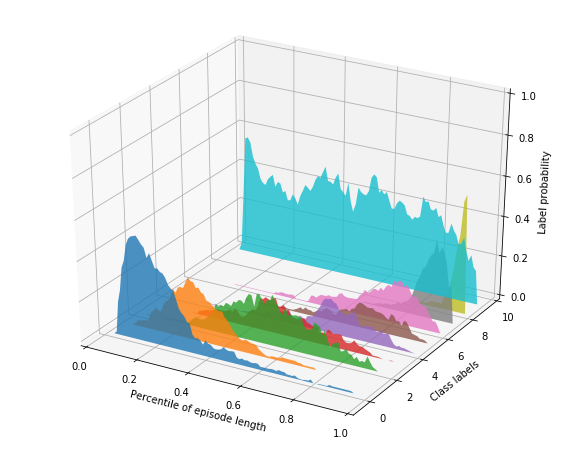

In [47]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.collections import PolyCollection
from matplotlib.collections import LineCollection
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
import numpy as np

ep_label_temporal_all = load_ep_label_temporal(EP_LIST)

label_temporal = compute_temporal_label_dist(ep_label_temporal_all)
label_temporal = label_temporal.transpose()

fig = plt.figure(figsize=(10,8))
ax = fig.gca(projection='3d')


def cc(arg):
    return mcolors.to_rgba(arg, alpha=0.6)

xs = np.arange(0, 1, 0.01)
verts = []
zs = range(len(label_list))
for i, z in enumerate(zs):
    ys = label_temporal[i]
    ys[0], ys[-1] = 0, 0
    verts.append(list(zip(xs, ys)))

poly = PolyCollection(verts, facecolors=[cc('C0'), cc('C1'), cc('C2'),
                                         cc('C3'),cc('C4'), cc('C5'), 
                                         cc('C6'), cc('C7'),cc('C8'), cc('C9')])
poly.set_alpha(0.8)
ax.add_collection3d(poly, zs=zs, zdir='y')

ax.set_xlabel('Percentile of episode length')
ax.set_xlim3d(0, 1)
ax.set_ylabel('Class labels')
ax.set_ylim3d(-1, 10)
ax.set_zlabel('Label probability')
ax.set_zlim3d(0, 1)

plt.show()

When running this baseline, the temporal distribution will be computed with only the training data instead of all episodes. This process may take some time (8 - 10 minutes).

In [48]:
bench_temporal_label_dist = {
                            'similarity': [],
                            'kl_divergence': [],
                            'label_similarity': [],
                            'label_kl_divergence': []
}
for i in range(1, 61):
    current_ep = group_ep[str(i)]
    ep_label_temporal = {j: ep_label_temporal_all[j] for j in ep_label_temporal_all if j != current_ep}
    label_temporal_dist = compute_temporal_label_dist(ep_label_temporal)
    
    test_data = X[np.array(GROUP_EP)==i]
    test_label = y[np.array(GROUP_EP)==i]
    bench_temporal_label_dist['similarity'].append(evaluation(test_data, test_label, 
                                                              rand_method='temporal_dist', 
                                                              label_temporal_dist=label_temporal_dist,
                                                              eval_method='similarity'))
    bench_temporal_label_dist['kl_divergence'].append(evaluation(test_data, test_label, 
                                                                 rand_method='temporal_dist', 
                                                                 label_temporal_dist=label_temporal_dist,
                                                                 eval_method='kl_divergence'))
    bench_temporal_label_dist['label_similarity'].append(evaluation(test_data, test_label, 
                                                                    rand_method='temporal_dist', 
                                                                    label_temporal_dist=label_temporal_dist,
                                                                    eval_method='label_similarity'))
    bench_temporal_label_dist['label_kl_divergence'].append(evaluation(test_data, test_label, 
                                                                       rand_method='temporal_dist', 
                                                                       label_temporal_dist=label_temporal_dist,
                                                                       eval_method='label_kl_divergence'))

/Users/liu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in double_scalars
  if __name__ == '__main__':
/Users/liu/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:2507: RuntimeWarning: invalid value encountered in true_divide
  pk = 1.0*pk / np.sum(pk, axis=0)


In [49]:
print('Similarity, temporal label distribution: ava. %.3f, std. %.3f' % 
      (np.average(bench_temporal_label_dist['similarity']), sem(bench_temporal_label_dist['similarity'])))
print('KL_divergence, temporal label distribution: ava. %.3f, std. %.3f' % 
      (np.average(bench_temporal_label_dist['kl_divergence']), sem(bench_temporal_label_dist['kl_divergence'])))

Similarity, temporal label distribution: ava. 0.728, std. 0.007
KL_divergence, temporal label distribution: ava. 0.867, std. 0.018


In [50]:
print('Label similarity, baseline_temporal_dist:')
print(np.nanmean(bench_temporal_label_dist['label_similarity'], axis=0))
print(sem(bench_temporal_label_dist['label_similarity'], axis=0, nan_policy='omit'))

Label similarity, baseline_temporal_dist:
[0.58695735 0.46109701 0.49103178 0.40440269 0.38502735 0.39060002
 0.50311022 0.63290586 0.85650431 0.84354254]
[0.022567349424050417 0.019359073786530564 0.018472480312295952
 0.016902762239603814 0.023695584453979308 0.023755909544280043
 0.023392896162186073 0.02518971509106889 0.026999170716484854
 0.008469308817316286]


In [51]:
print('Label kl_divergence, baseline_temporal_dist:')
print(np.nanmean(bench_temporal_label_dist['label_kl_divergence'], axis=0))
print(sem(bench_temporal_label_dist['label_kl_divergence'], axis=0, nan_policy='omit'))

Label kl_divergence, baseline_temporal_dist:
[1.36890971 1.7276017  1.45686028 1.97723051 2.11389909 2.18313797
 1.61365279 1.14798648 0.54134431 0.29732828]
[0.08639304951771092 0.0704788604333193 0.07439783823201153
 0.09259870696675024 0.09328339824527061 0.13203145188122595
 0.08313814672987062 0.07796128997795591 0.08021323389697352
 0.018992242546813726]


## Run t-test

In [ ]:
print("P-value: label_dist vs most_common: ")
print(ttest_rel(bench_similarity_most_common['kl_divergence'], 
                bench_label_dist['kl_divergence'], 
                nan_policy='omit'))
print('\n')
print("P-value: logistic regression vs label_dist: ")
print(ttest_rel(-logistic_baseline['test_KL_divergence'], 
                bench_label_dist['kl_divergence'], 
                nan_policy='omit'))
print('\n')
print("P-value: temporal label dist vs logistic regression: ")
print(ttest_rel(-logistic_baseline['test_KL_divergence'], 
                bench_temporal_label_dist['kl_divergence'], 
                nan_policy='omit'))
print('\n')
print("P-value: XGBoost vs temporal label dist: ")
print(ttest_rel(scores_ova_xgb_all['test_KL_divergence'], 
                bench_temporal_label_dist['kl_divergence'], 
                nan_policy='omit'))

## Label wise statistical analysis
Since temporal label distribution baseline is the strongest, we only run statistical analysis between this baseline and XGBoost rather than all baselines.

In [ ]:
# Similarity
for i in range(10):
    xgboost_label_similarity = [ep[i] for ep in model_label_similarity['XGBoost']]
    temporal_label_similarity = [ep[i] for ep in bench_temporal_label_dist['label_similarity']]
    print("P-value for label:", label_list[i])
    print(ttest_rel(temporal_label_similarity, xgboost_label_similarity, nan_policy='omit')[1])

In [ ]:
# KL divergence
for i in range(10):
    xgboost_label_kl = [ep[i] for ep in model_kl_divergence['XGBoost']]
    temporal_label_kl = [ep[i] for ep in bench_temporal_label_dist['label_kl_divergence']]
    print("P-value for label:", label_list[i])
    print(ttest_rel(temporal_label_kl, xgboost_label_kl, nan_policy='omit')[1])

Plotting label wise performance.

In [ ]:
#KL divergence
bar_width = 0.4
r1 = 2*np.arange(10)
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]
r4 = [x + bar_width for x in r3]

pyplot.rcParams.update({'font.size': 16})

fig = pyplot.figure(figsize=(12,8))

pyplot.bar(r1, 
           np.nanmean(bench_label_dist['label_kl_divergence'], axis=0), 
           yerr=1.95*sem(bench_label_dist['label_kl_divergence'], nan_policy='omit'),
           width=bar_width,
           capsize=3,
           color='red',
           label='Label_dist'
          )
pyplot.bar(r2, 
           np.nanmean(model_kl_divergence['Logistic'], axis=0), 
           yerr=1.95*sem(model_kl_divergence['Logistic'], nan_policy='omit'),
           width=bar_width,
           capsize=3,
           color='purple',
           label='Logistic_regression'
          )
pyplot.bar(r3, 
           np.nanmean(bench_temporal_label_dist['label_kl_divergence'], axis=0), 
           yerr=1.95*sem(bench_temporal_label_dist['label_kl_divergence'], nan_policy='omit'),
           width=bar_width,
           capsize=3,
           color='blue',
           label='Temporal_label_dist'
          )

pyplot.bar(r4, 
           np.nanmean(model_kl_divergence['XGBoost'], axis=0), 
           yerr=1.95*sem(model_kl_divergence['XGBoost'], nan_policy='omit'),
           width=bar_width,
           capsize=3,
           color='cyan',
           label='XGBoost'
          )

pyplot.xticks([2*(r + 0.75*bar_width) for r in range(10)], label_list, rotation='60')
pyplot.ylabel('KL_divergence')
pyplot.legend(ncol=2)

pyplot.show()

In [ ]:
# Cosine similarity
fig2 = pyplot.figure(figsize=(12,8))

pyplot.bar(r1, 
           np.nanmean(bench_label_dist['label_similarity'], axis=0), 
           yerr=1.95*sem(bench_label_dist['label_similarity'], nan_policy='omit'),
           width=bar_width,
           capsize=3,
           color='red',
           label='Label_dist'
          )
pyplot.bar(r2, 
           np.nanmean(model_label_similarity['Logistic'], axis=0), 
           yerr=1.95*sem(model_label_similarity['Logistic'], nan_policy='omit'),
           width=bar_width,
           capsize=3,
           color='purple',
           label='Logistic_regression'
          )
pyplot.bar(r3, 
           np.nanmean(bench_temporal_label_dist['label_similarity'], axis=0), 
           yerr=1.95*sem(bench_temporal_label_dist['label_similarity'], nan_policy='omit'),
           width=bar_width,
           capsize=3,
           color='blue',
           label='Temporal_label_dist'
          )

pyplot.bar(r4, 
           np.nanmean(model_label_similarity['XGBoost'], axis=0), 
           yerr=1.95*sem(model_label_similarity['XGBoost'], nan_policy='omit'),
           width=bar_width,
           capsize=3,
           color='cyan',
           label='XGBoost'
          )

pyplot.xticks([2*(r + 0.75*bar_width) for r in range(10)], label_list, rotation='60')
pyplot.ylabel('Cosine similarity')
pyplot.legend(ncol=2)

pyplot.show()